In [1]:
import sklearn, json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
expert_network = json.load(open('expert_network.json'))

In [12]:
exp_set = list(expert_network.keys())
peer_friends = dict()
for exp in expert_network:
    first_degree = set(expert_network[exp]['following']) & set(exp_set)
    second_degree = []
    for exp2 in first_degree:
        second_degree.extend(expert_network[exp2]['following'])
    second_degree = [i for i in second_degree if i in exp_set]
    peer_friends[exp] = (len(second_degree), Counter(second_degree))

In [14]:
peer_friends_2 = dict()
for exp in peer_friends:
    length = peer_friends[exp][0]
    if length == 0: 
        peer_friends_2[exp] = dict()
        continue
    dct = peer_friends[exp][1]
    peer_friends_2[exp] = {ex:dct[ex]/length for ex in dct}

In [16]:
peer_friends_2['paulwinfree']

{'KL_Pham': 0.003102699348433137,
 'joelgriffith': 0.00589512876202296,
 'teedabb': 0.0012410797393732546,
 'scottzipperle': 0.003102699348433137,
 'GaryJSchmitt1': 0.000930809804529941,
 'Virginia_Allen5': 0.004964318957493019,
 'MHowellTweets': 0.004033509152963078,
 'pj_geller': 0.0012410797393732546,
 'thomaswright08': 0.0012410797393732546,
 'LukeKarnick': 0.0027924294135898233,
 'ConStelz': 0.0012410797393732546,
 'JustinRheeASC': 0.0024821594787465093,
 'MaloneySuzanne': 0.0015513496742165685,
 'A_Sloat': 0.001861619609059882,
 'lora_ries': 0.004964318957493019,
 'torrey_taussig': 0.00031026993484331366,
 'LeeWEdwards': 0.004654049022649705,
 'KironSkinner': 0.0024821594787465093,
 'NRobinson1297': 0.0012410797393732546,
 'continetti': 0.006825938566552901,
 'Twitter': 0.001861619609059882,
 'CharmaineYoest': 0.006515668631709587,
 'junghpak1': 0.000930809804529941,
 'ColleenAHarmon': 0.003723239218119764,
 'kevinrkosar': 0.0021718895439031957,
 'adamnmichel': 0.0071362085013962

In [3]:
info1 = pd.read_csv('complete_data_centrality.csv')
data = pd.read_csv('complete_data.csv').drop(['title', 'type'], axis=1)
data = data[~data['type'].isin(['other', 'N'])]
data = data[~data['twitter'].isin(['-1', 'Twitter', 'MarshallJenA', 'sarahfiggatt'])]
data = data.drop_duplicates(subset = ['twitter'])

expert_data = data.set_index('twitter').T.to_dict()
expert_data['chrisbachmann'].keys()

dict_keys(['expert_id', 'name', 'institution', 'type', 'num_opinions', 'num_testimony', 'num_press', 'num_external', 'is_resident', 'is_senior', 'is_leadership', 'is_phd', 'is_law', 'num_tweets', 'num_following', 'num_followers'])

In [ ]:
from itertools import permutations
A_follow_B = list(permutations(data['twitter'], 2))
int_data = pd.DataFrame({'from':[i[0] for i in A_follow_B], 'to': [i[1] for i in A_follow_B]})
int_data['is_edge'] = int_data[['from', 'to']].apply(lambda x: x[1] in 
                                expert_network[x[0]]['following'], axis=1)

In [5]:
full_data = int_data.merge(data, left_on = 'from', right_on = 'twitter')
full_data = full_data.merge(data, left_on = 'to', right_on = 'twitter')

In [6]:
full_data['share_institution'] = full_data['institution_x'] == full_data['institution_y']
full_data['more_tweets'] = (full_data['num_tweets_y'] - full_data['num_tweets_x'])/ full_data['num_tweets_x']
full_data['more_followers'] = (full_data['num_followers_y'] - 
                               full_data['num_followers_x'])/ full_data['num_followers_x']
full_data['more_following'] = (full_data['num_following_y'] - 
                               full_data['num_following_x'])/ full_data['num_following_x']

In [7]:
full_data['higher_rank'] = full_data[['is_leadership_x', 'is_senior_x', 
                                      'is_leadership_y', 'is_senior_y']].apply(lambda x: 
                                      ((x[2]=='Y') | (x[3] == 'Y')) and ((x[0] =='N') & (x[1] == 'N')), axis =1)
full_data['head'] = full_data[['share_institution', 'higher_rank']].apply(lambda x: x[0]&x[1], axis=1)


In [8]:
full_data['higher_degree'] = full_data[['is_phd_x', 'is_phd_y']].apply(lambda x: 
                             (x[0] == 'N') & (x[1]=='Y'), axis=1)

In [9]:
full_data.to_csv('data4analysis.csv', index=False)

## With other information integrated

In [34]:
import sklearn, json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
full_data = pd.read_csv('data4analysis.csv')

In [22]:
def match_friends(x):
    exp1, exp2 = x
    try: return peer_friends_2[exp1][exp2]
    except KeyError: return 0
full_data['sec_deg_following'] = full_data[['twitter_x', 
                                            'twitter_y']].apply(match_friends, axis=1)

In [36]:
full_data['more_opinions'] = full_data['num_opinions_y']- full_data['num_opinions_x']
full_data['more_testimony'] = full_data['num_testimony_y']- full_data['num_testimony_x']
full_data['more_press'] = full_data['num_press_y']- full_data['num_press_x']
full_data['more_external'] = full_data['num_external_y']- full_data['num_external_x']
#full_data = full_data[col_lst]
full_data.to_csv('data4analysis.csv', index=False)

In [69]:
col_lst = [#'from', 'to', 
           'is_edge', 
           #'expert_id_x', 'expert_id_y',
           #'name_x', 'name_y', 
           #'twitter_x','twitter_y',
            'institution_x', 'institution_y',
            #'num_opinions_x', 'num_testimony_x', 'num_press_x', 'num_external_x',
            'num_opinions_y', 'num_testimony_y', 'num_press_y', 'num_external_y',
            'more_opinions', 'more_testimony', 'more_press', 'more_external',
            'is_resident_x', 'is_resident_y', 
            'is_senior_x', 'is_senior_y', 
            'is_leadership_x', 'is_leadership_y',
            'is_phd_x', 'is_phd_y',
            'is_law_x', 'is_law_y',
           #'num_tweets_x', 'num_tweets_y',
           #'num_following_x', 'num_followers_x', 
           #'num_following_y', 'num_followers_y',
           #'tweet_freq_x', 'tweet_freq_y', 
            'share_institution', 'higher_rank', 'head',
            'more_tweets', 'more_followers', 'more_following',  
            'tweet_freq_diff', 'tweet_similarity',
            'higher_degree', 'topic_similarity', 
            'retweeted', 'at', 'share_links',
            'sec_deg_following']

In [101]:
target_data = full_data[col_lst].dropna().copy()

for col in target_data.columns:
    if ('is_' in col) and (col not in ['is_edge']):
        target_data[col] = target_data[col].apply(lambda x: x=='Y')
    
target_data['is_aei_x'] = target_data['institution_x'].apply(lambda x: x=='aei')
target_data['is_cap_x'] = target_data['institution_x'].apply(lambda x: x=='cap')
target_data['is_heritage_x'] = target_data['institution_x'].apply(lambda x: x=='heritage')
target_data = target_data.drop(['institution_x', 'institution_y'], axis=1)

scale_lst = [
    'num_opinions_x', 'num_testimony_x', 'num_press_x', 'num_external_x',
    'num_opinions_y', 'num_testimony_y', 'num_press_y', 'num_external_y',
    'more_opinions', 'more_testimony', 'more_press', 'more_external',
    'more_tweets', 'more_followers', 'more_following', 
    'tweet_freq_diff', 'tweet_similarity',
    'higher_degree', 'topic_similarity', 
    'retweeted', 'at', 'share_links',
    'sec_deg_following']

for col in scale_lst:
    if col not in target_data.columns: continue
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(target_data[[col]])
    target_data[col] = scaler.transform(target_data[[col]])
    
scale_lst  =['topic_similarity',"tweet_similarity"]
for col in scale_lst:
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(target_data[[col]])
    target_data[col] = scaler.transform(target_data[[col]])
        
target_data['topic_similarity^2'] = target_data['topic_similarity']**2
target_data['tweet_similarity^2'] = target_data['tweet_similarity']**2
target_data = target_data.replace([np.inf, -np.inf], np.nan)
target_data = target_data.dropna()

In [102]:
X = target_data.drop(['is_edge'], axis=1)
y = target_data['is_edge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(np.mean(y_test), np.mean(y_train))
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test)), clf.score(X_test, y_test)
#mean accuracy on the given test data and labels.

0.053717446574589434 0.05247077185852696


(0.5585921325051759, 0.9633752490895348)

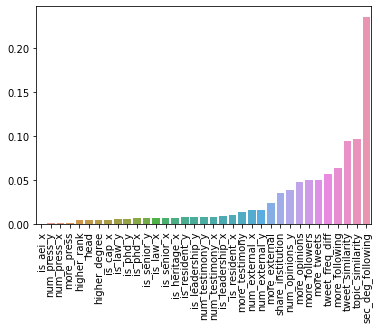

In [57]:
vis = sorted(list(zip(X.columns, clf.feature_importances_))[1:], key = lambda x:x[1])
ax = sns.barplot(x=[i[0] for i in vis], y=[i[1] for i in vis])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [110]:
X = target_data.drop(['is_edge', 'more_following', 
                      'more_followers', 'tweet_similarity',
                      'tweet_freq_diff', 'more_tweets'], axis=1)
y = target_data['is_edge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(np.mean(y_test), np.mean(y_train))
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print(f1_score(y_test, clf.predict(X_test)), clf.score(X_test, y_test))
#mean accuracy on the given test data and labels.
pred = clf.predict(X_test)
print(f1_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred))

0.053717446574589434 0.05247077185852696
0.5495181464014763 0.9622586408300694
0.5495181464014763 0.4285257435241445 0.7657142857142857


In [104]:
X = target_data.drop(['is_edge', 'more_following', 
                      'more_followers', 'tweet_similarity',
                      'tweet_freq_diff', 'more_tweets',
                      'sec_deg_following'], axis=1)
y = target_data['is_edge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(np.mean(y_test), np.mean(y_train))
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print(f1_score(y_test, clf.predict(X_test)), clf.score(X_test, y_test))
#mean accuracy on the given test data and labels.

0.053717446574589434 0.05247077185852696
0.4869302225102614 0.9592008520579949


In [109]:
from sklearn.metrics import recall_score, precision_score
pred = clf.predict(X_test)
f1_score(y_test, pred), recall_score(y_test, pred), precision_score(y_test, pred)

(0.4869302225102614, 0.36040933802366487, 0.7503328894806924)

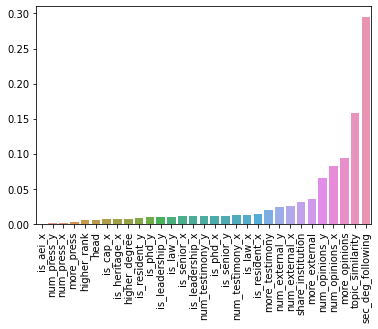

In [61]:
vis = sorted(list(zip(X.columns, clf.feature_importances_)), key = lambda x:x[1])
ax = sns.barplot(x=[i[0] for i in vis], y=[i[1] for i in vis])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [79]:
X['sec_deg_following'].mean()

0.02089371794710867

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.32')

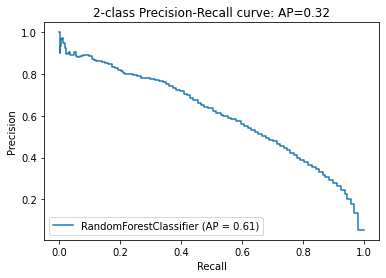

In [84]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = clf.predict(X_test)
average_precision = average_precision_score(y_test, y_score)

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [80]:
X = target_data.drop(['retweeted', 'at', 'share_links','is_edge'], axis=1)
y = target_data['is_edge']

X_const = sm.add_constant(X)
logit = sm.Logit(y, X_const.astype(float)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.125706
         Iterations 23
                           Logit Regression Results                           
Dep. Variable:                is_edge   No. Observations:               194040
Model:                          Logit   Df Residuals:                   194007
Method:                           MLE   Df Model:                           32
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:                  0.3922
Time:                        11:56:45   Log-Likelihood:                -24392.
converged:                       True   LL-Null:                       -40129.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.1182      0.560    -12.714      0.000      -8.216      -6.021
num_opi

/Users/chenliang/opt/anaconda3/envs/R-Python/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [115]:
X = target_data.drop(['is_edge', 
                      #'num_followers_x','num_followers_y',
                      #'num_following_y', 'num_following_x', 
                      #'num_opinions_x', 'num_testimony_x', 
                      #'tweet_freq_x', 'tweet_freq_y',
                      #'num_press_x', 'num_external_x',
                    'more_tweets', 'more_followers', 'more_following',
                      'tweet_freq_diff', 'tweet_similarity',
                      'retweeted', 'at', 'share_links'
                      ], axis=1)
y = target_data['is_edge']

X_const = sm.add_constant(X)
logit = sm.Logit(y, X_const.astype(float)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.125684
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                is_edge   No. Observations:               194040
Model:                          Logit   Df Residuals:                   194010
Method:                           MLE   Df Model:                           29
Date:                Sat, 26 Sep 2020   Pseudo R-squ.:                  0.3923
Time:                        14:55:15   Log-Likelihood:                -24388.
converged:                       True   LL-Null:                       -40129.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.1430      0.559    -12.776      0.000      -8.239      -6.047
num_

In [28]:
X['tweet_freq_x'][X['tweet_freq_x'].isna()]

Series([], Name: tweet_freq_x, dtype: float64)

In [9]:
from sklearn import feature_selection as fs
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings("ignore")

In [57]:
for i in range(10, 28):
    sel_f = SelectKBest(fs.f_classif, k=i)
    X_train_f = sel_f.fit_transform(X_train, y_train)
    X_test_f = sel_f.transform(X_test)
    #print(X.columns[sel_f.get_support()])
    clf = RandomForestClassifier(random_state=0).fit(X_train_f, y_train)
    print(i, f1_score(y_test, clf.predict(X_test_f)), 
          clf.score(X_test_f, y_test))

10 0.35471698113207545 0.9483045296518365
11 0.349320882852292 0.9485060714465662
12 0.3419243986254296 0.9485396617456878
13 0.34383202099737536 0.9496145513175794
14 0.3453427065026362 0.9499504543087957
15 0.34299516908212563 0.9497489125140659
16 0.348334054521852 0.9494130095228498
17 0.34155929242192623 0.9493626240741674
18 0.3435097737755326 0.9497992979627483
19 0.34661354581673304 0.9504207184964982
20 0.3968789540278363 0.9519658722560924
21 0.3962465344423118 0.9524529315933559
22 0.4143459915611814 0.9533766648192002
23 0.42387178405735976 0.9541156513998758
24 0.43584350021034923 0.9549554088779161
25 0.44153686396677055 0.9548378428309904
26 0.4337148803329865 0.9543003980450446
27 0.4308077645585473 0.9541996271476797


<AxesSubplot:xlabel='is_edge', ylabel='topic_similarity'>

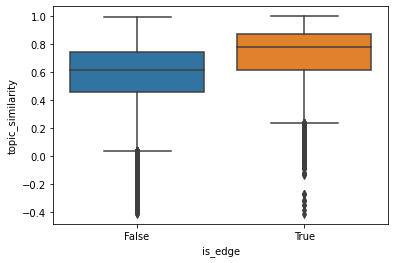

In [260]:
sns.boxplot(y='topic_similarity', x='is_edge', data= target_data)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 128.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 273.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100}

In [21]:
f1_score(y_test, rf_random.best_estimator_.predict(X_test))

0.4589656240322081

In [ ]:
rf_random.best_estimator_.score(X_test, y_test)